# Multi-task TF-Modisco Workflow for DeepSea
This notebook uses the modisco package to extract motifs for CEBPB(337), E2F6(340), Egr-1(341) and ELF1(342) from DeepSEA model. More modisco tutorials and documentations can be found here: https://github.com/kundajelab/tfmodisco 

In [1]:
# Select Environment(conda_kipoi-shared__env__kipoi-py3-keras2)
import os
import sys
import time
import h5py
import torch
import scipy.io
import numpy as np
from collections import Counter
from collections import OrderedDict
import seaborn as sns
import matplotlib.pyplot as plt

# kipoi
import kipoi
import kipoi_interpret
from kipoi_veff.utils.plot import seqlogo_heatmap

# Gradient-based methods
from kipoi_interpret.importance_scores.gradient import Gradient, GradientXInput
from kipoi_interpret.importance_scores.referencebased import DeepLift

# tf-modisco
import modisco
import modisco.visualization
from modisco.visualization import viz_sequence

# tf-modisco workflow
import modisco.backend
import modisco.nearest_neighbors
import modisco.affinitymat
import modisco.affinitymat.core
import modisco.tfmodisco_workflow.seqlets_to_patterns
import modisco.tfmodisco_workflow.workflow
import modisco.tfmodisco_workflow
import modisco.aggregator
import modisco.cluster
import modisco.cluster.core
import modisco.cluster.phenograph.core
import modisco.cluster.phenograph.cluster
import modisco.value_provider
import modisco.core
import modisco.coordproducers
import modisco.metaclusterers
import modisco.clusterinit.memeinit
import modisco.util

/home/ubuntu/anaconda3/envs/kipoi-shared__envs__kipoi-py3-keras2/lib/python3.6/site-packages/kipoi_veff/external/concise/seqplotting_deps.py:34: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  min_coords = np.vstack(data.min(0) for data in polygons_data).min(0)
/home/ubuntu/anaconda3/envs/kipoi-shared__envs__kipoi-py3-keras2/lib/python3.6/site-packages/kipoi_veff/external/concise/seqplotting_deps.py:35: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  max_coords = np.vstack(data.max(0) for data in polygons_data).max(0)
TF-MoDISco is using the TensorFlow backend.
/home/ubuntu/anaconda3/envs/kipoi-shared__envs__kipoi-py3-keras2/lib/python3.6/site-packages/ten

In [2]:
### set the path
data_dir = '../../../data/deepsea_train/'
result_dir = '../../../out/importance scores/DeepSea/'

### Import data and pre-computed importance scores

In [3]:
with open(data_dir + 'X_test_sample.npy', 'rb') as f:
    X_test_sample = np.load(f)
X_test_sample = X_test_sample.squeeze().transpose((0, 2, 1))

In [4]:
print(X_test_sample.shape)

(10000, 1000, 4)


In [5]:
scores = OrderedDict()
hypothetical_scores = OrderedDict()
tasks = ['CEBPB(337)', 'E2F6(340)', 'Egr-1(341)', 'ELF1(342)']
path = '../../../out/importance scores/DeepSea/'

with open(path + 'CEBPB_scores.npy', 'rb') as f:
    scores[tasks[0]] = np.load(f) 
with open(path + 'CEBPB_hyp_scores.npy', 'rb') as f:
    hypothetical_scores[tasks[0]] = np.load(f) 
    
with open(path + 'E2F6_scores.npy', 'rb') as f:
    scores[tasks[1]] = np.load(f) 
with open(path + 'E2F6_hyp_scores.npy', 'rb') as f:
    hypothetical_scores[tasks[1]] = np.load(f) 
    
with open(path + 'Egr-1_scores.npy', 'rb') as f:
    scores[tasks[2]] = np.load(f) 
with open(path + 'Egr-1_hyp_scores.npy', 'rb') as f:
    hypothetical_scores[tasks[2]] = np.load(f) 
    
with open(path + 'ELF1_scores.npy', 'rb') as f:
    scores[tasks[3]] = np.load(f) 
with open(path + 'ELF1_hyp_scores.npy', 'rb') as f:
    hypothetical_scores[tasks[3]] = np.load(f) 

### Multi-task TF-MoDISco
Selected TFs: CEBPB(337), E2F6(340), Egr-1(341) and ELF1(342)

In [ ]:
null_per_pos_scores = modisco.coordproducers.LaplaceNullDist(num_to_samp=5000)
tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
    sliding_window_size = 15,
    flank_size = 5,
    target_seqlet_fdr = 0.15,
    seqlets_to_patterns_factory = modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
#         initclusterer_factory=modisco.clusterinit.memeinit.MemeInitClustererFactory(
#             #meme_command="meme", base_outdir="meme_out",   
#             #max_num_seqlets_to_use specifies the maximum number of seqlets to use
#             # with MEME (this is to speed up MEME in the cases where the number of seqlets is
#             #  very large)
#             max_num_seqlets_to_use=10000,
#             nmotifs=10,
#             n_jobs=4),
        #use_louvain=False,
        #Adjust trim_to_window_size and initial_flank_to_add
        # according to how big you expect
        # the core motif to be; default value is 10
        #trim_to_window_size=6,
        #initial_flank_to_add=2,
        #final_flank_to_add=5,
        #kmer_len, num_gaps and num_mismatches are used to
        # derive kmer embeddings for coarse-grained affinity
        # matrix calculation. kmer_len=6, num_gaps=1
        # and num_mismatches=0 means
        # that kmer embeddings using 6-mers with 1 gap will be
        # used.
        trim_to_window_size=15,
        initial_flank_to_add=5,
        kmer_len=5,
        num_gaps=1,
        num_mismatches=0,
        final_min_cluster_size=60))(
    #There is only one task, so we just call this 'task0'
    task_names = tasks,
    contrib_scores = scores,                
    hypothetical_contribs = hypothetical_scores,
    one_hot = X_test_sample,
    null_per_pos_scores=null_per_pos_scores)

### Save results for future use

In [ ]:
grp = h5py.File('../../../out/modisco/multi_task_deepsea_modisco.hdf5')
tfmodisco_results.save_hdf5(grp)

### Load saved results

In [6]:
from modisco.tfmodisco_workflow import workflow

tasks = ['CEBPB(337)', 'E2F6(340)', 'Egr-1(341)', 'ELF1(342)']
track_set = modisco.tfmodisco_workflow.workflow.prep_track_set(task_names = tasks,
                                                               contrib_scores = scores,
                                                               hypothetical_contribs = hypothetical_scores,
                                                               one_hot = X_test_sample)

grp = h5py.File("../../../out/modisco/multi_task_deepsea_modisco.hdf5","r")
loaded_tfmodisco_results = workflow.TfModiscoResults.from_hdf5(grp, track_set = track_set)
grp.close()

### Analyze results

#### I. Check metaclusters

In [7]:
# Check the number of metaclusters and seqlets considered for each
from collections import Counter
y = np.array(loaded_tfmodisco_results.metaclustering_results.metacluster_indices)
cnt = Counter(y)
cnt

Counter({-1: 7426,
         13: 1550,
         17: 1240,
         8: 2663,
         0: 24353,
         10: 2451,
         2: 3856,
         3: 3745,
         6: 3091,
         12: 1725,
         1: 17195,
         5: 3114,
         11: 1871,
         7: 3044,
         14: 1422,
         16: 1244,
         20: 1011,
         4: 3357,
         9: 2610,
         19: 1066,
         21: 1008,
         18: 1140,
         15: 1399})

In [8]:
hdf5_results = h5py.File("../../../out/modisco/multi_task_deepsea_modisco.hdf5","r")
metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]
metacluster_names

['metacluster_0',
 'metacluster_1',
 'metacluster_2',
 'metacluster_3',
 'metacluster_4',
 'metacluster_5',
 'metacluster_6',
 'metacluster_7',
 'metacluster_8',
 'metacluster_9',
 'metacluster_10',
 'metacluster_11',
 'metacluster_12',
 'metacluster_13',
 'metacluster_14',
 'metacluster_15',
 'metacluster_16',
 'metacluster_17',
 'metacluster_18',
 'metacluster_19',
 'metacluster_20',
 'metacluster_21']

In [54]:
all_patterns = []
background = np.array([0.27, 0.23, 0.23, 0.27])

for metacluster_name in metacluster_names:
    print(metacluster_name)
    
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    
    print('number of patterns: ', len(all_pattern_names))
    
#     if (len(all_pattern_names)==0):
#         print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        print('----------------')
hdf5_results.close()

metacluster_0
activity pattern: [-1 -1 -1 -1]
number of patterns:  13
metacluster_0 pattern_0
total seqlets: 2441
----------------
metacluster_0 pattern_1
total seqlets: 1757
----------------
metacluster_0 pattern_2
total seqlets: 1288
----------------
metacluster_0 pattern_3
total seqlets: 932
----------------
metacluster_0 pattern_4
total seqlets: 915
----------------
metacluster_0 pattern_5
total seqlets: 582
----------------
metacluster_0 pattern_6
total seqlets: 298
----------------
metacluster_0 pattern_7
total seqlets: 230
----------------
metacluster_0 pattern_8
total seqlets: 170
----------------
metacluster_0 pattern_9
total seqlets: 160
----------------
metacluster_0 pattern_10
total seqlets: 102
----------------
metacluster_0 pattern_11
total seqlets: 157
----------------
metacluster_0 pattern_12
total seqlets: 85
----------------
metacluster_1
activity pattern: [1 1 1 1]
number of patterns:  16
metacluster_1 pattern_0
total seqlets: 2235
----------------
metacluster_1 patt

#### II. Heatmap

Metaclusters heatmap
(91581, 4)


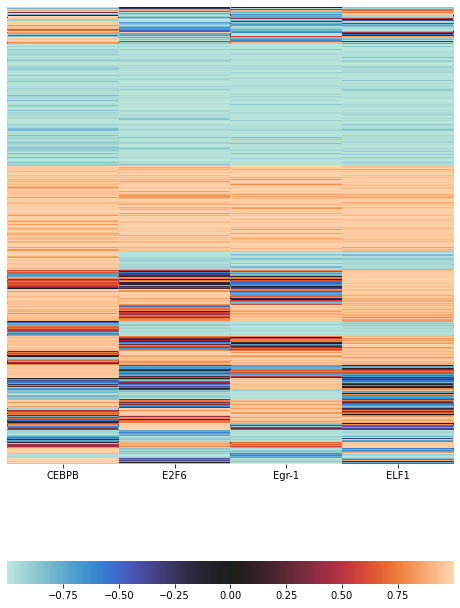

In [10]:
# hdf5_results = h5py.File("../out/modisco/multi_task_deepsea_modisco.hdf5","r")
figure_dir = '../../../out/figures/'
### heatmap
print("Metaclusters heatmap")
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[np.array([x[0] for x in sorted(enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
print(activity_patterns.shape)


plt.figure(figsize=(8,12))
sns.heatmap(activity_patterns, center=0, yticklabels = False, 
            xticklabels = ['CEBPB','E2F6', 'Egr-1', 'ELF1'], 
            cbar_kws={'orientation': 'horizontal'})
sns.set(font_scale=1.4)
plt.savefig(figure_dir + 'heatmap.png', bbox_inches = "tight", dpi = 1200)

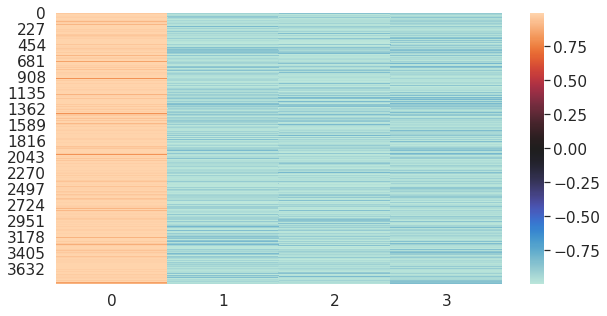

In [12]:
# metacluster 2
start = 0
for i in range(2):
    start = start + cnt[i]
start = start + cnt[-1]
end = start + cnt[2]
plt.figure(figsize=(10,5))
sns.heatmap(activity_patterns[start:end], center=0)
# plt.show()
plt.savefig(figure_dir + 'heatmap_M2_CEBPB.png', bbox_inches = "tight")

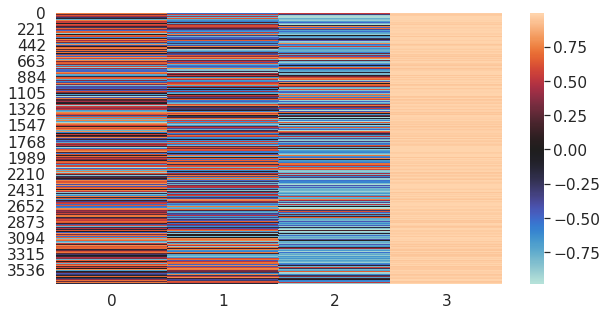

In [13]:
# metacluster 3
start = 0
for i in range(3):
    start = start + cnt[i]
start = start + cnt[-1]
end = start + cnt[3]
plt.figure(figsize=(10,5))
sns.heatmap(activity_patterns[start:end], center=0)
# plt.show()
plt.savefig(figure_dir + 'heatmap_M3_ELF1.png', bbox_inches = "tight")

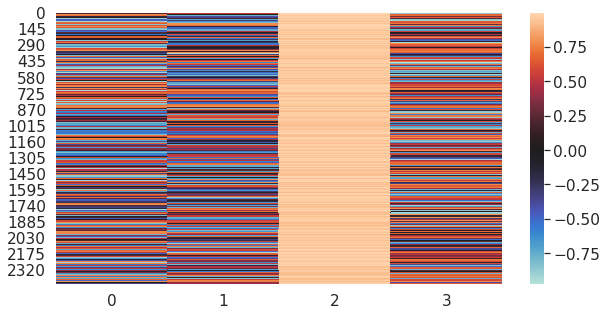

In [14]:
# metacluster 10: [1,-1,-1,-1] for TF ERG1
start = 0
for i in range(10):
    start = start + cnt[i]
start = start + cnt[-1]
end = start + cnt[10]
plt.figure(figsize=(10,5))
sns.heatmap(activity_patterns[start:end], center=0)
# plt.show()
plt.savefig(figure_dir + 'heatmap_M10_ERG1.png', bbox_inches = "tight")

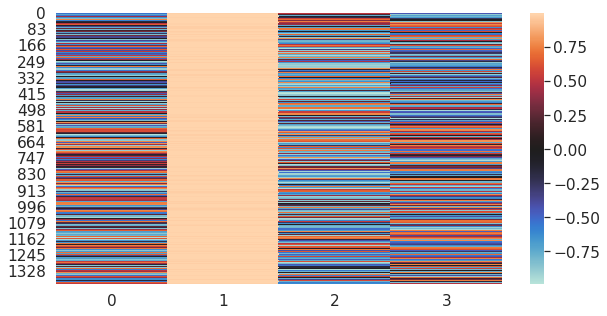

In [15]:
# metacluster 15: [1,-1,-1,-1] for TF ERG1
start = 0
for i in range(15):
    start = start + cnt[i]
start = start + cnt[-1]
end = start + cnt[15]
plt.figure(figsize=(10,5))
sns.heatmap(activity_patterns[start:end], center=0)
# plt.show()
plt.savefig(figure_dir + 'heatmap_M15_E2F6.png', bbox_inches = "tight")

#### III. Trim and plot motifs

metacluster_0 0


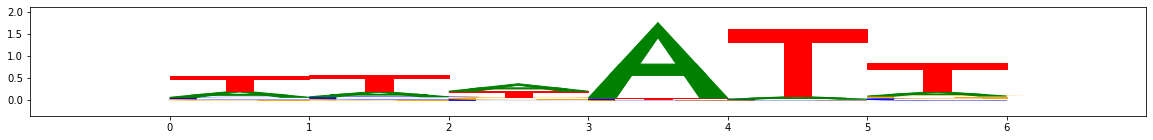

metacluster_0 1


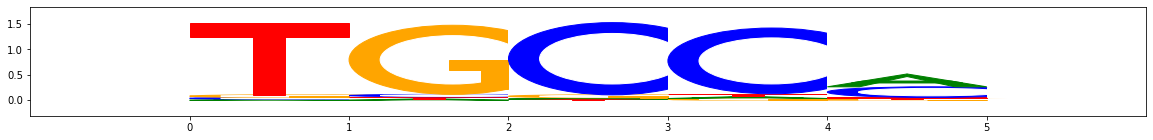

metacluster_0 2


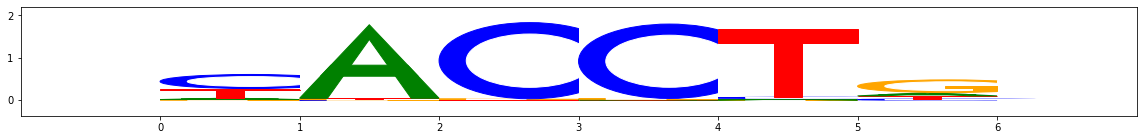

metacluster_0 3


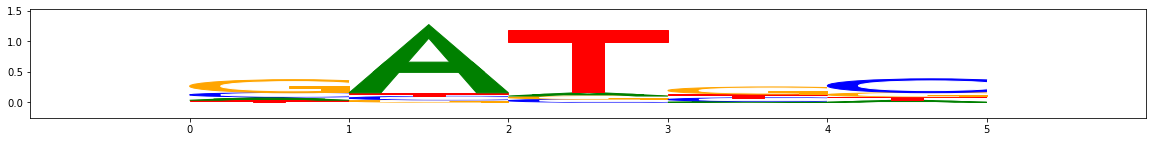

metacluster_0 4


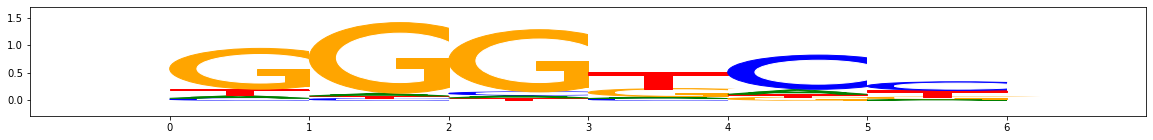

metacluster_0 5


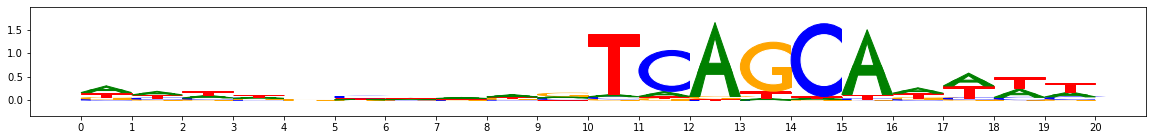

metacluster_0 6


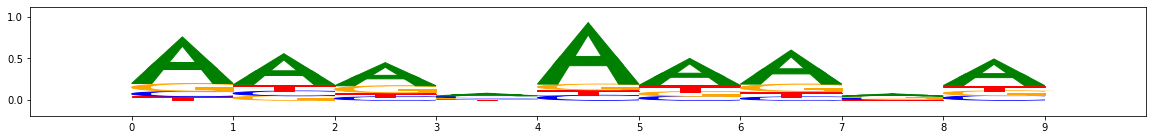

metacluster_0 7


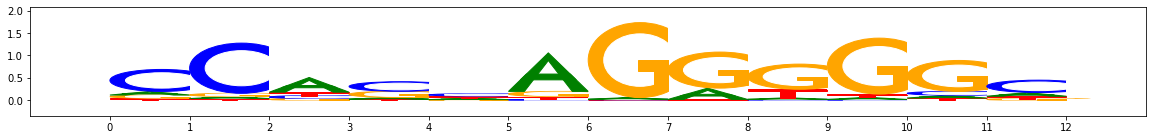

metacluster_0 8


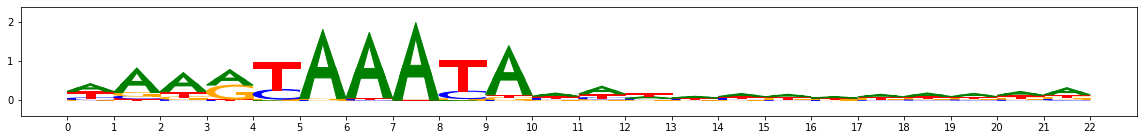

metacluster_0 9


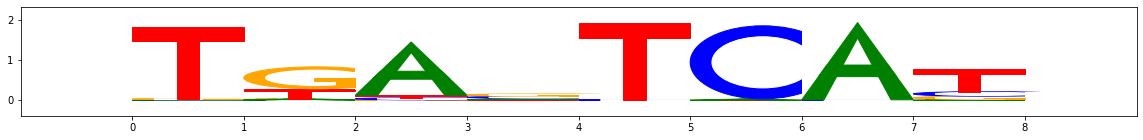

metacluster_0 10


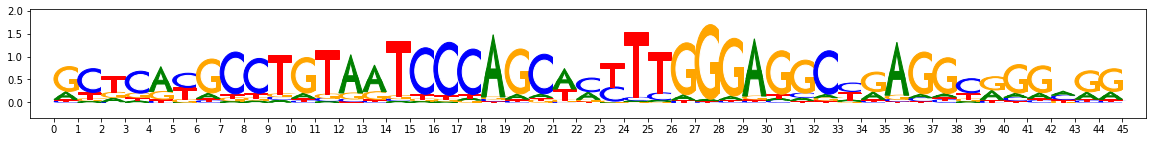

metacluster_0 11


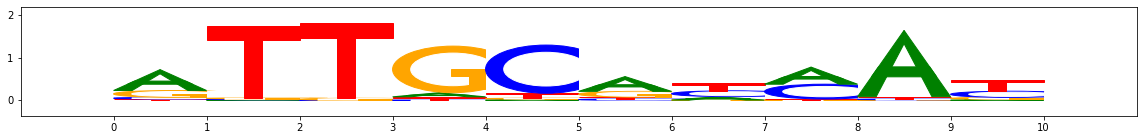

metacluster_0 12


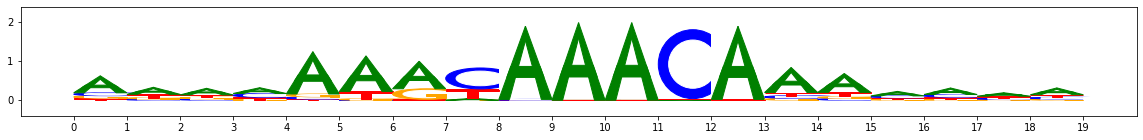

metacluster_1 0


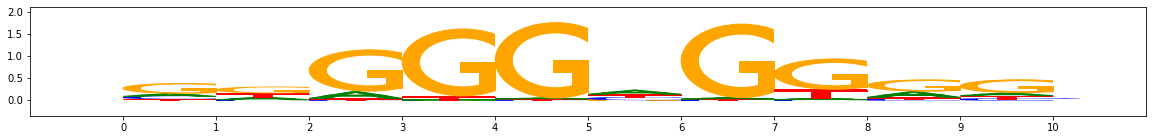

metacluster_1 1
Removed 1 duplicate seqlets


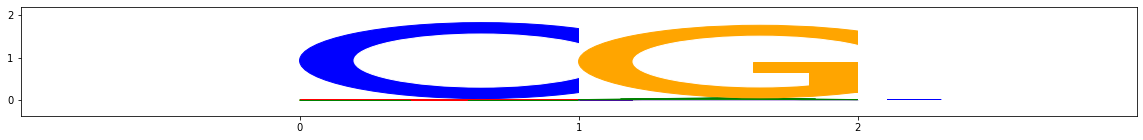

metacluster_1 2


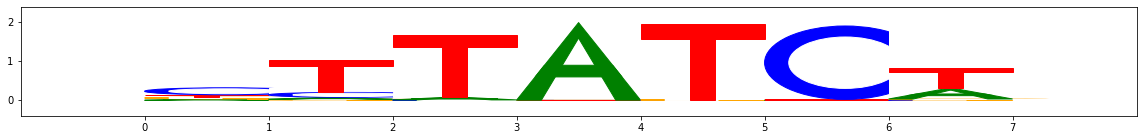

metacluster_1 3


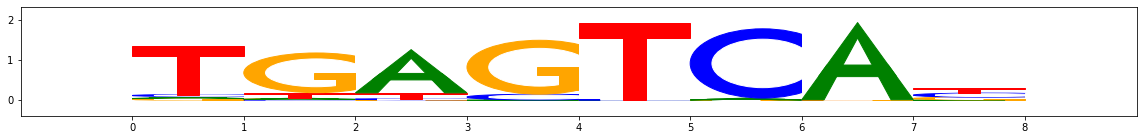

metacluster_1 4


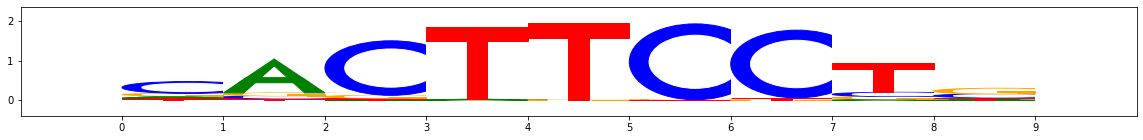

metacluster_1 5


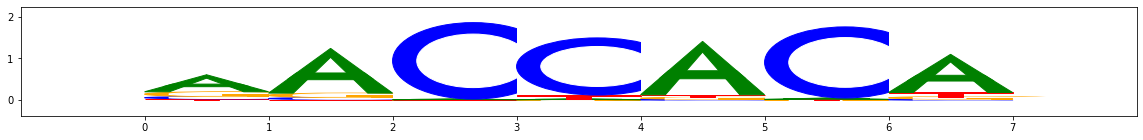

metacluster_1 6


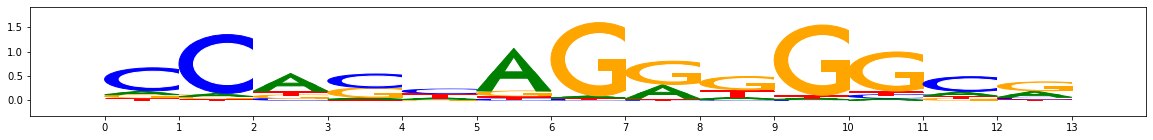

metacluster_1 7


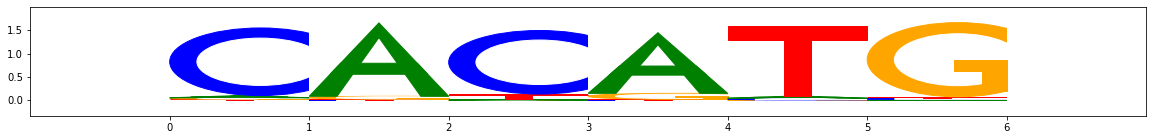

metacluster_1 8


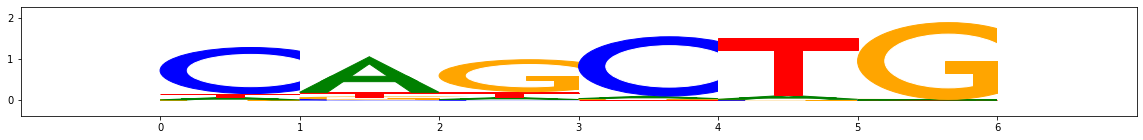

metacluster_1 9


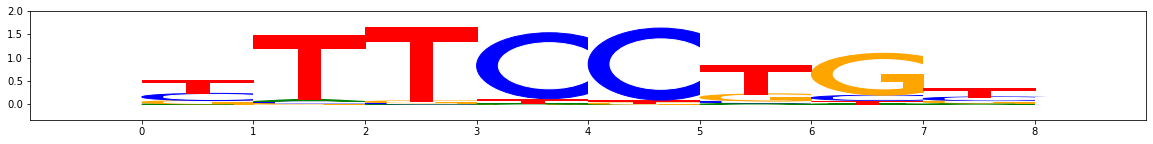

metacluster_1 10


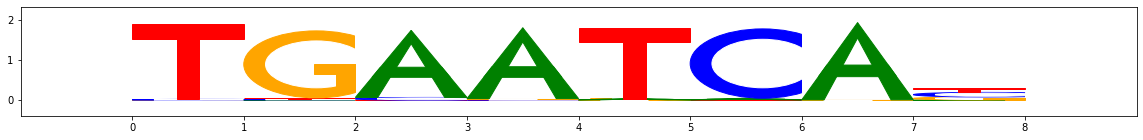

metacluster_1 11


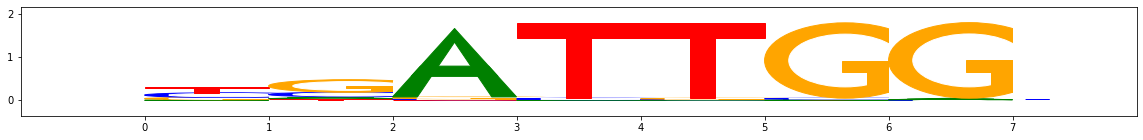

metacluster_1 12


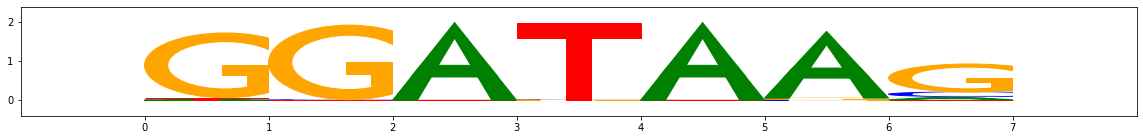

metacluster_1 13


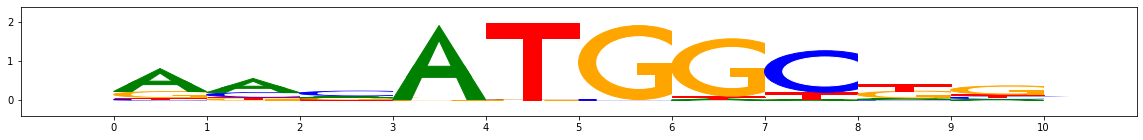

metacluster_1 14


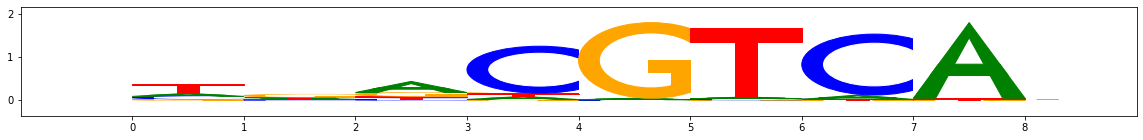

metacluster_1 15


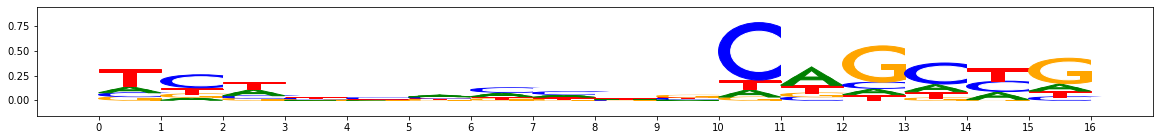

metacluster_2 0


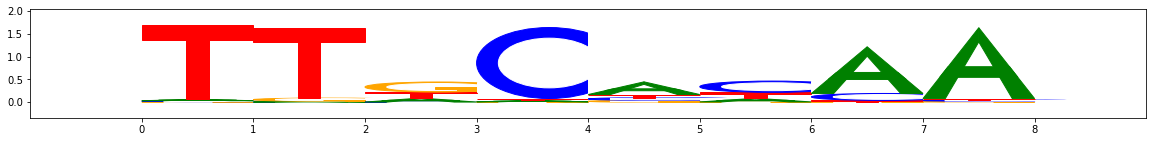

metacluster_2 1


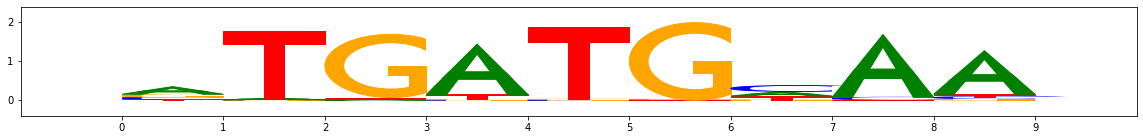

metacluster_2 2


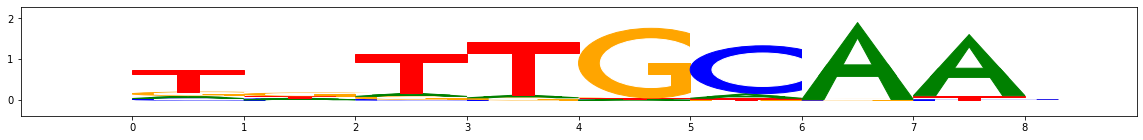

metacluster_2 3


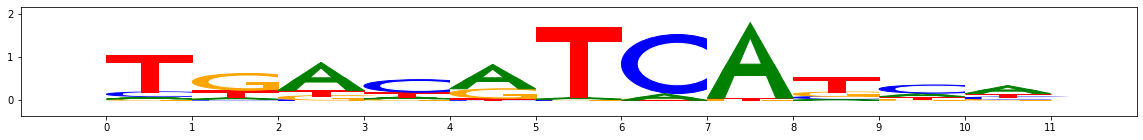

metacluster_3 0


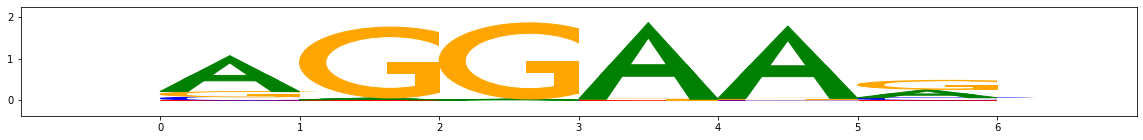

metacluster_3 1


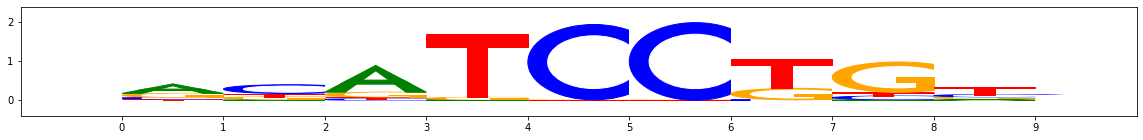

metacluster_3 2


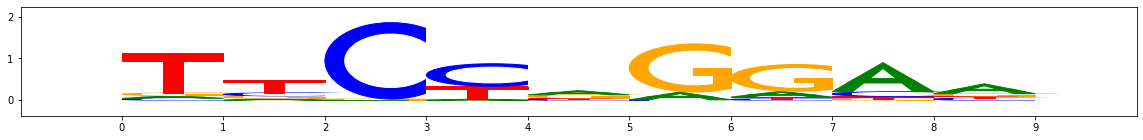

metacluster_3 3


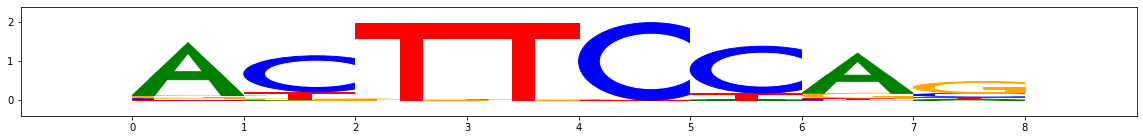

metacluster_3 4


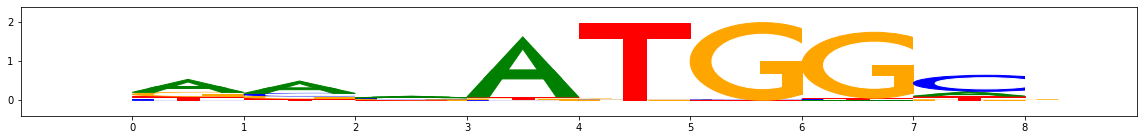

metacluster_4 0


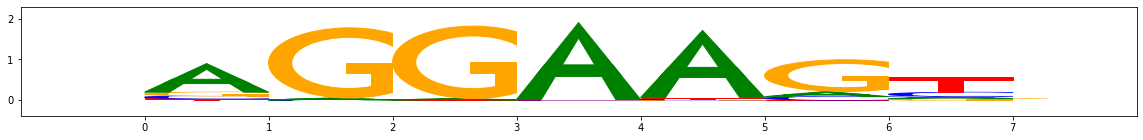

metacluster_4 1


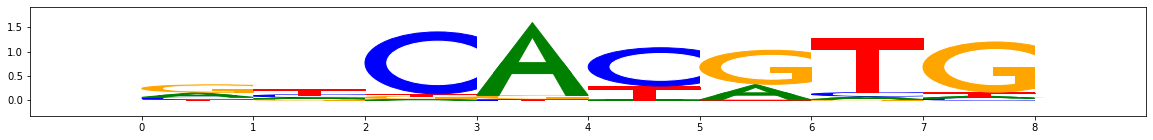

metacluster_4 2


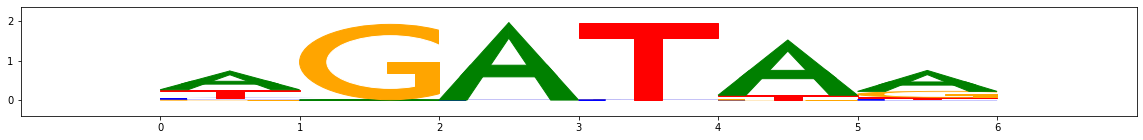

metacluster_4 3


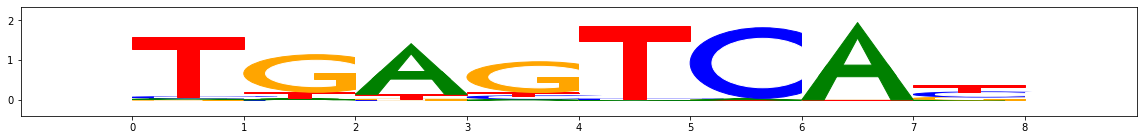

metacluster_4 4


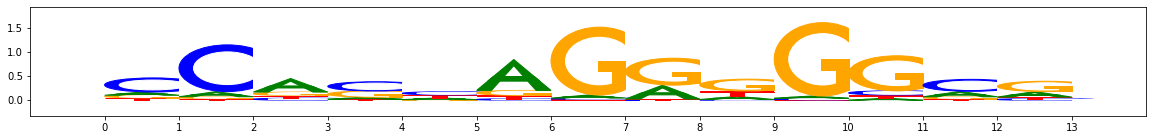

metacluster_4 5


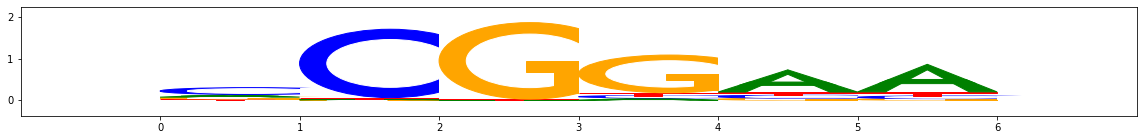

metacluster_4 6


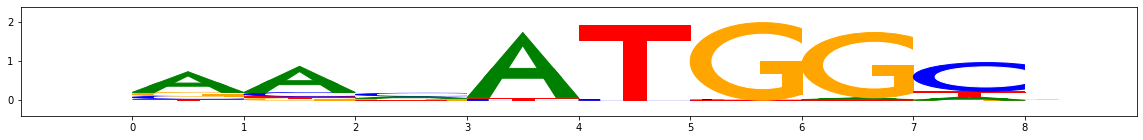

metacluster_4 7


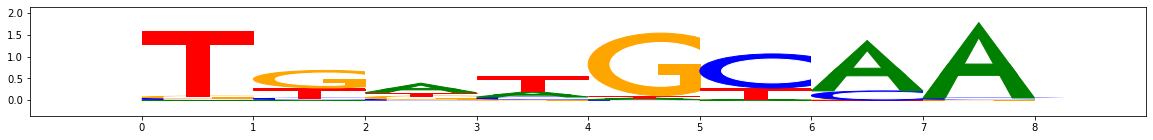

metacluster_4 8


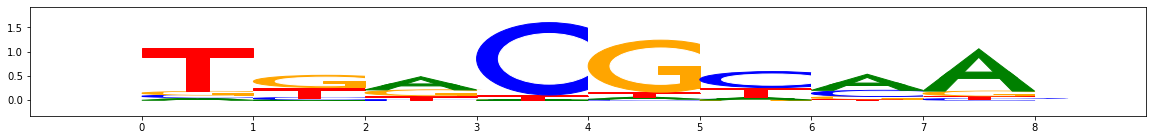

metacluster_5 0


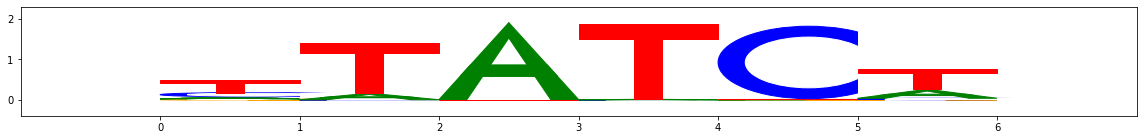

metacluster_5 1


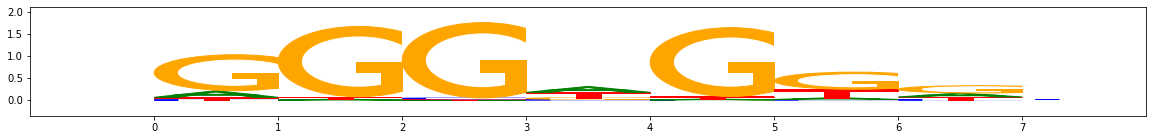

metacluster_5 2


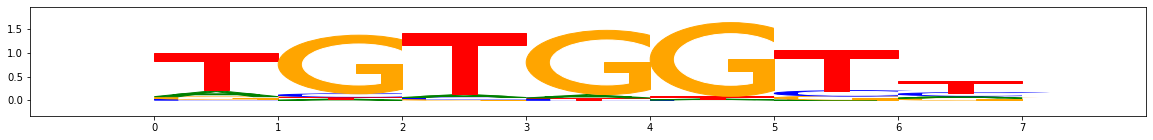

metacluster_5 3


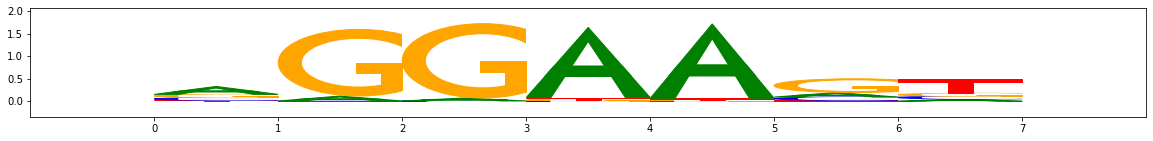

metacluster_5 4


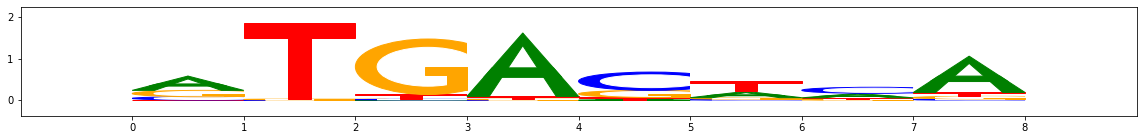

metacluster_5 5


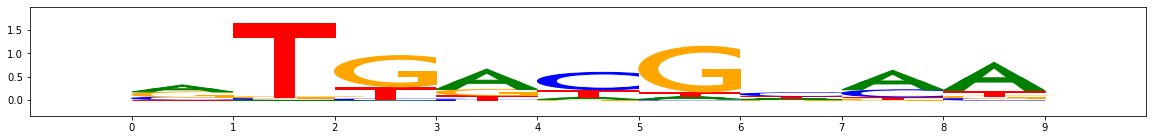

metacluster_5 6


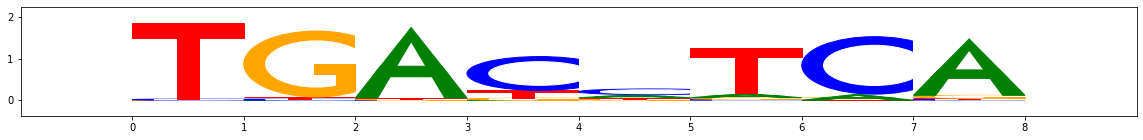

metacluster_6 0


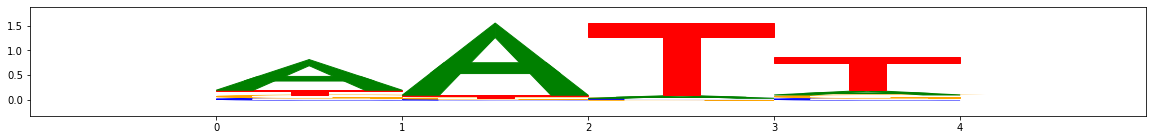

metacluster_6 1


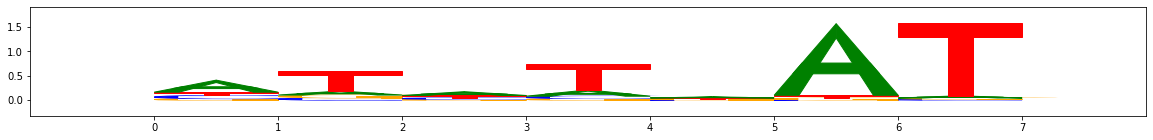

metacluster_6 2


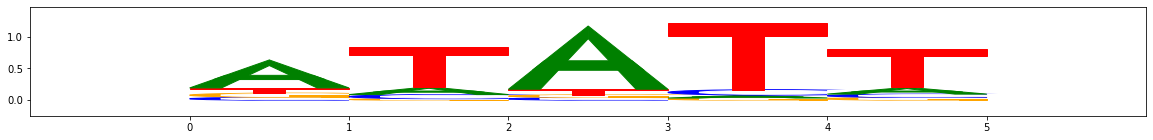

metacluster_6 3


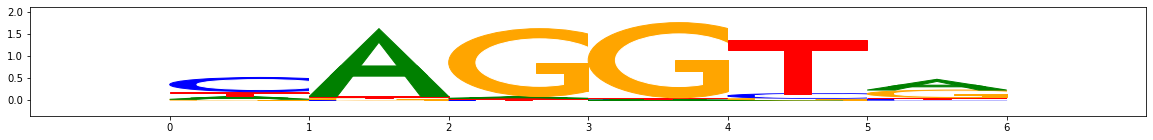

metacluster_6 4


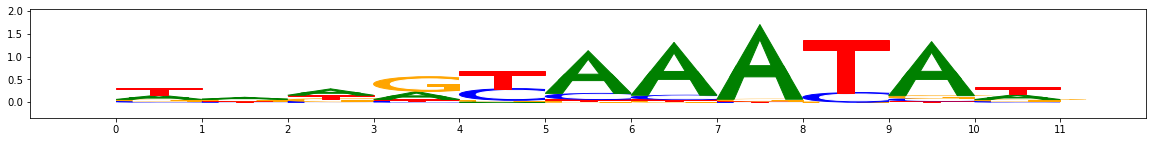

metacluster_6 5


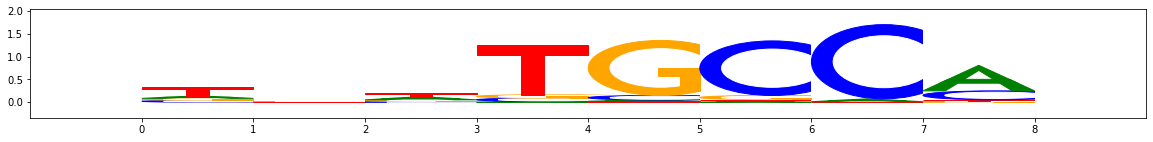

metacluster_6 6


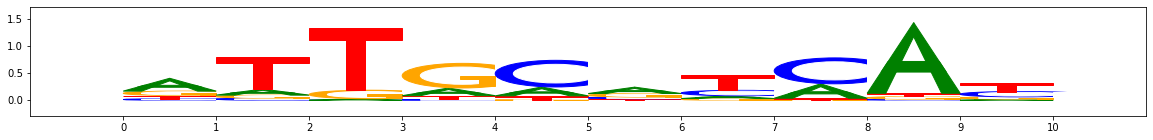

metacluster_6 7


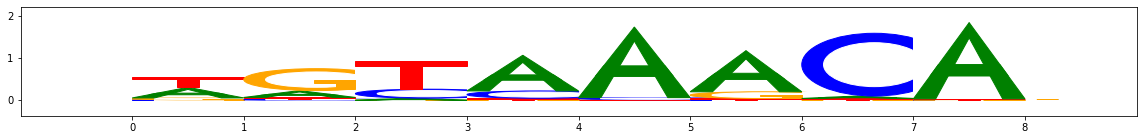

metacluster_7 0


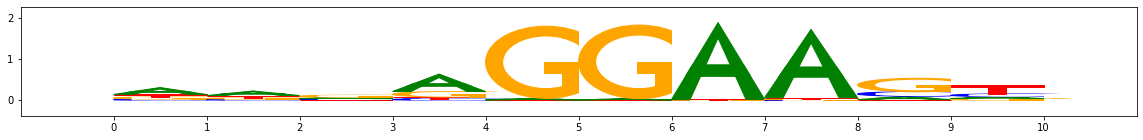

metacluster_7 1


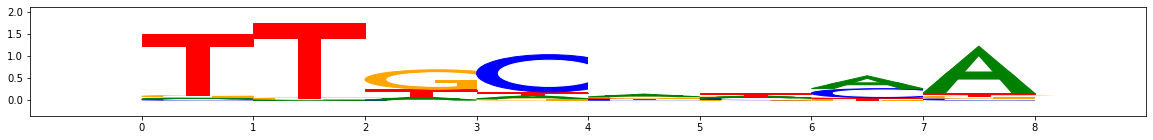

metacluster_7 2


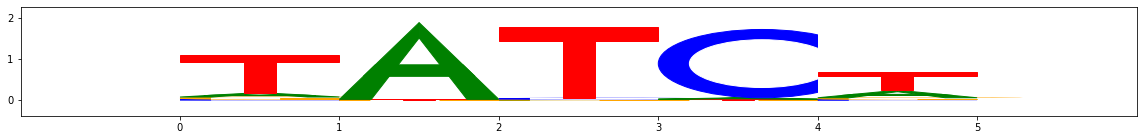

metacluster_7 3


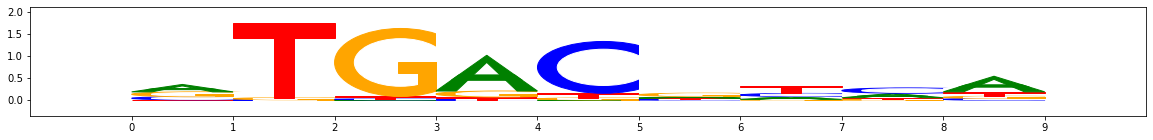

metacluster_7 4


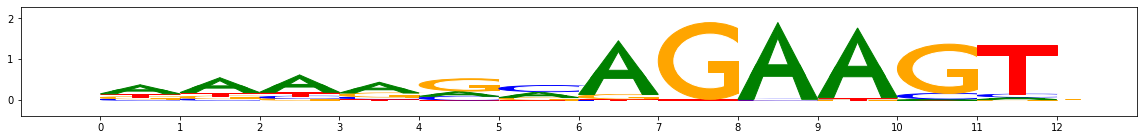

metacluster_7 5


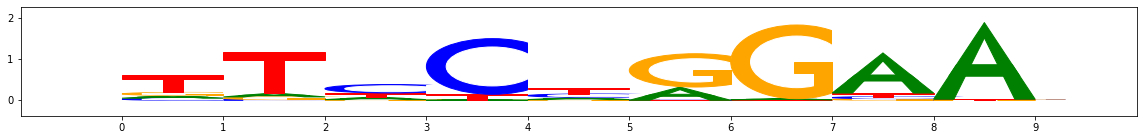

metacluster_8 0


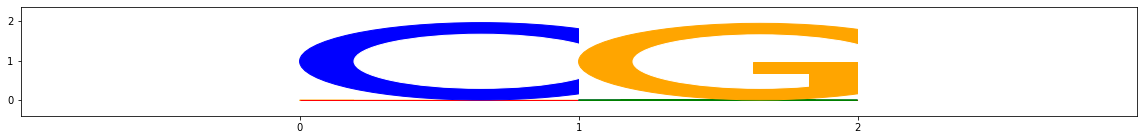

metacluster_8 1


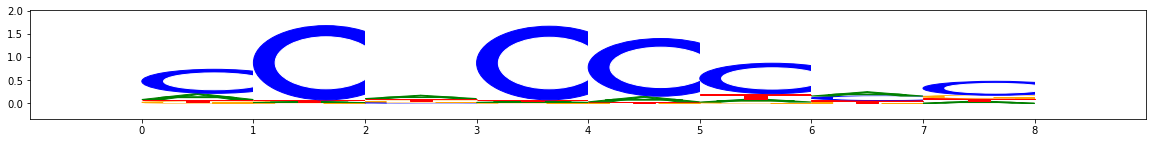

metacluster_8 2


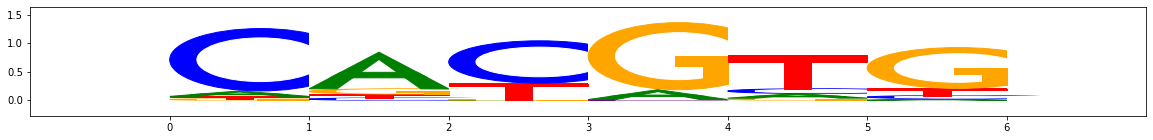

metacluster_8 3


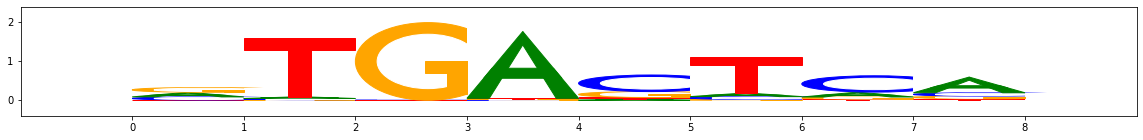

metacluster_8 4


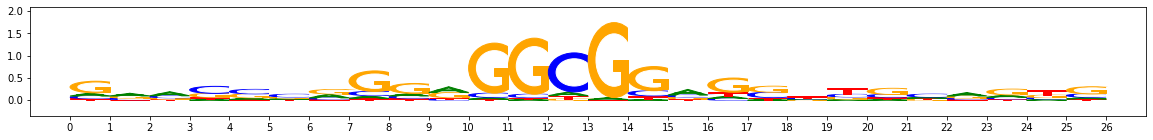

metacluster_9 0


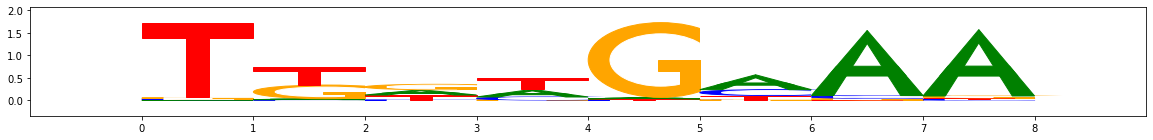

metacluster_9 1


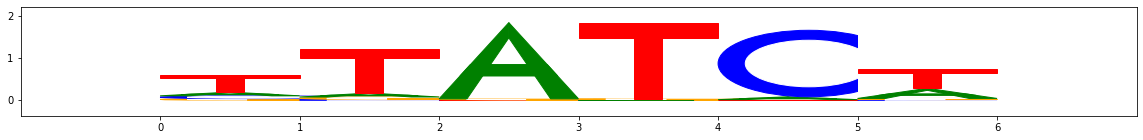

metacluster_9 2


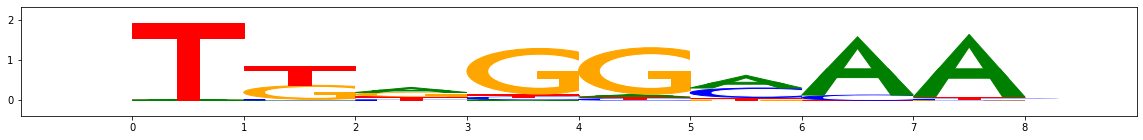

metacluster_9 3


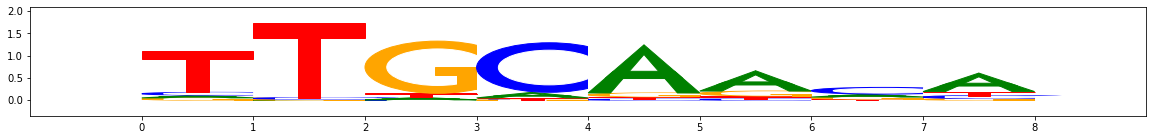

metacluster_9 4


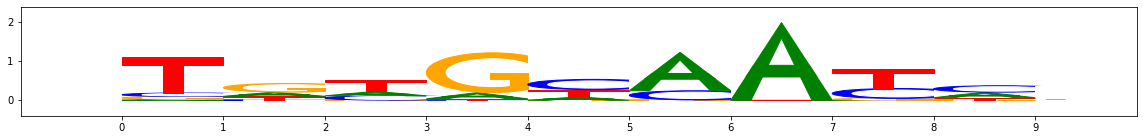

metacluster_9 5


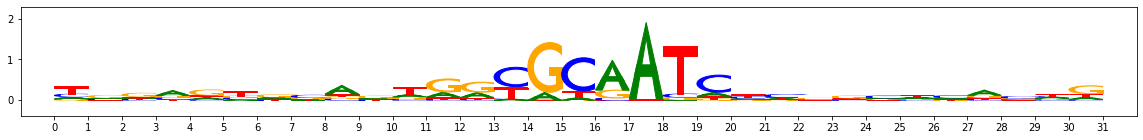

metacluster_10 0


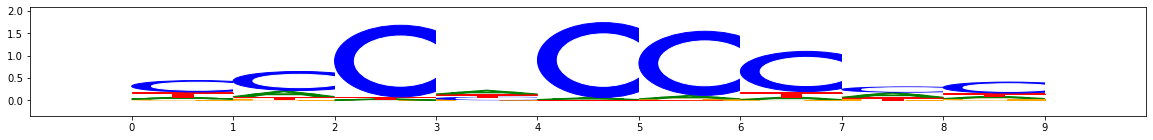

metacluster_10 1


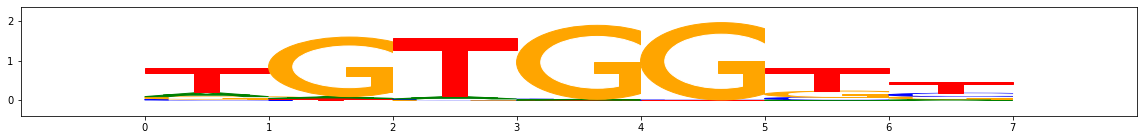

metacluster_10 2


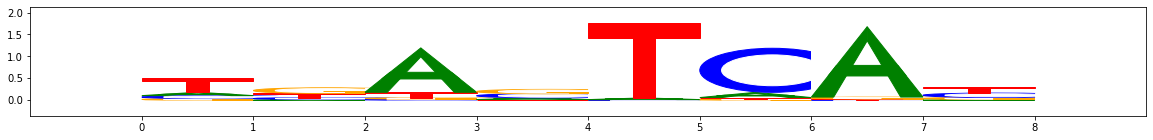

metacluster_10 3


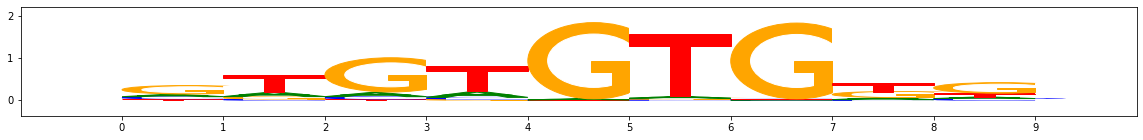

metacluster_10 4


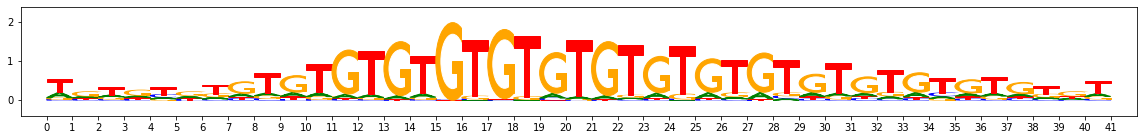

metacluster_11 0


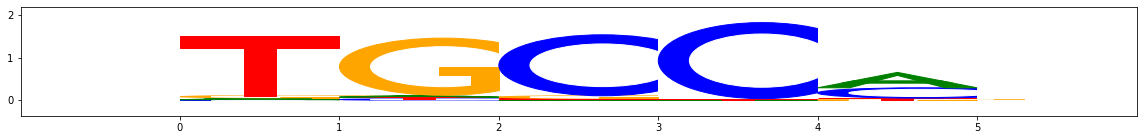

metacluster_11 1


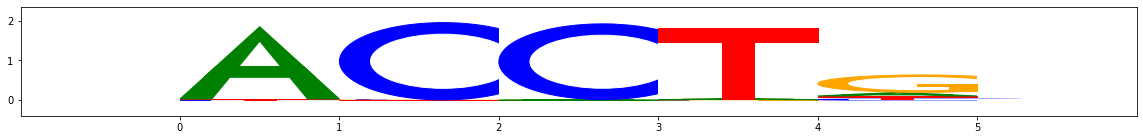

metacluster_11 2


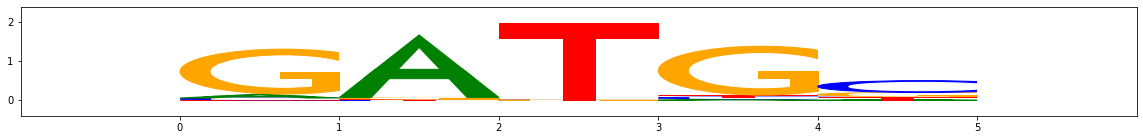

metacluster_11 3


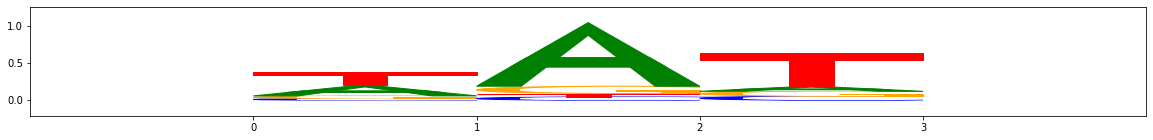

metacluster_11 4


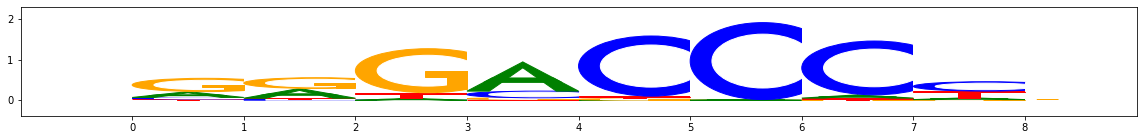

metacluster_12 0


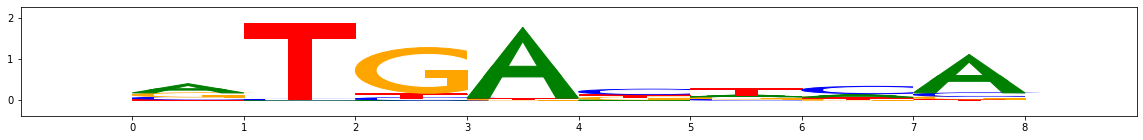

metacluster_12 1


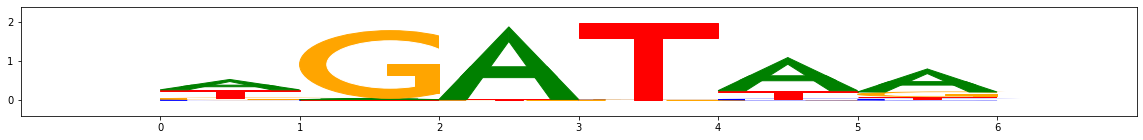

metacluster_12 2


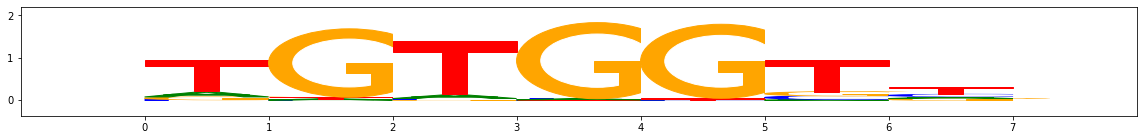

metacluster_12 3


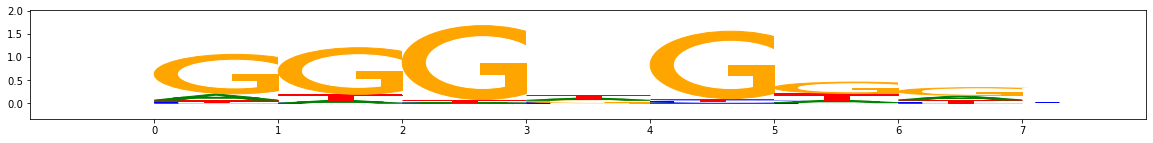

metacluster_12 4


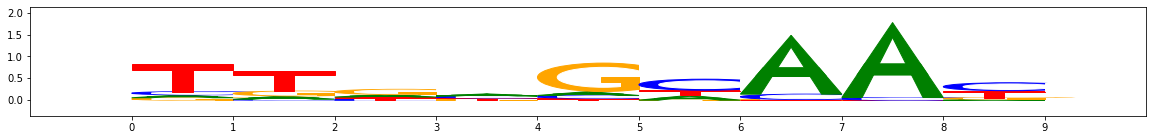

metacluster_13 0


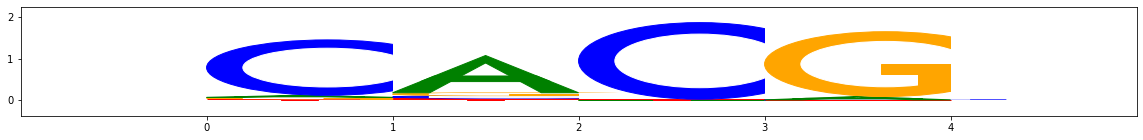

metacluster_13 1


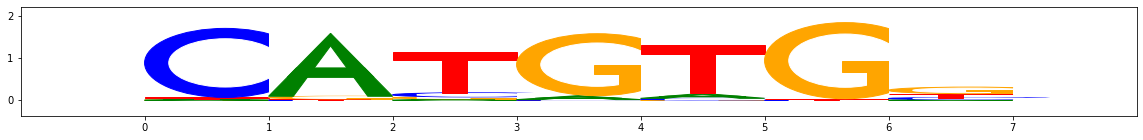

metacluster_13 2


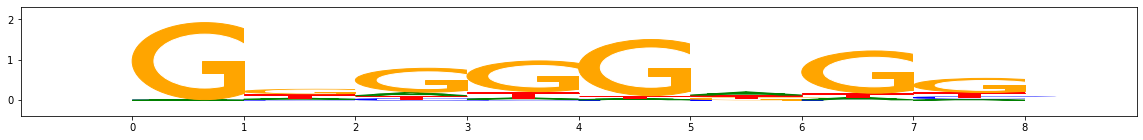

metacluster_13 3


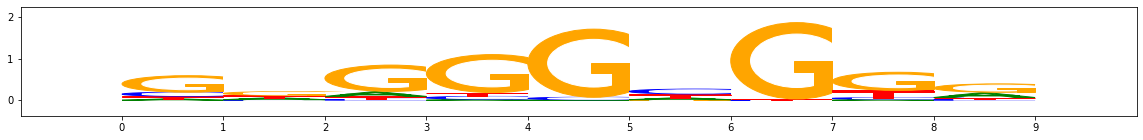

metacluster_14 0


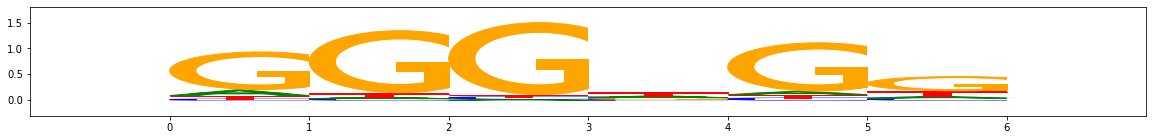

metacluster_14 1


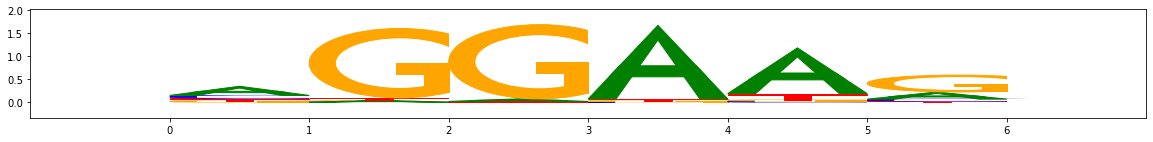

metacluster_14 2


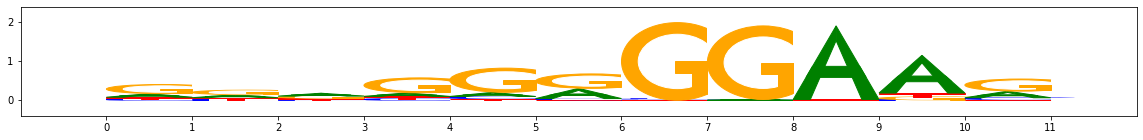

metacluster_14 3


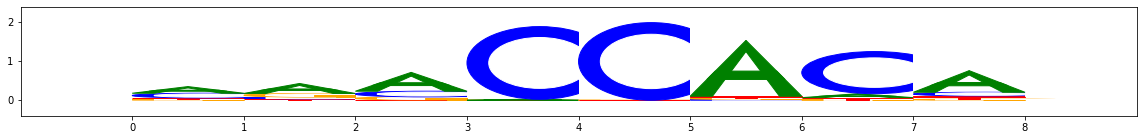

metacluster_15 0


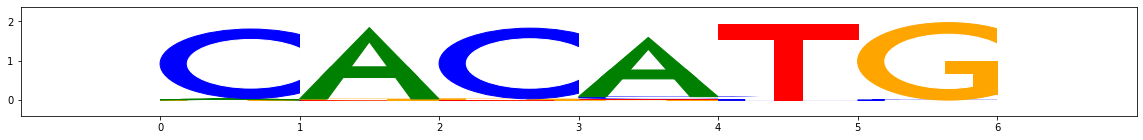

metacluster_15 1


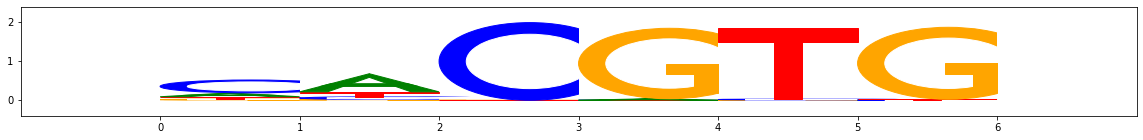

metacluster_16 0


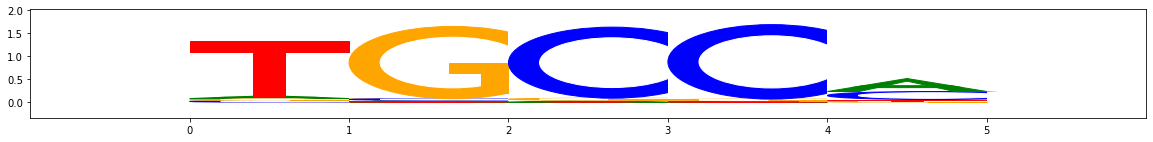

metacluster_16 1


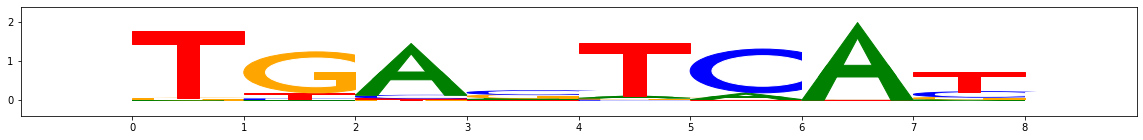

metacluster_16 2


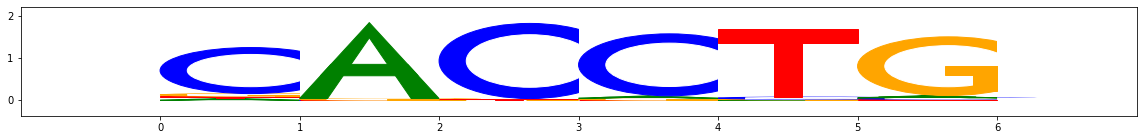

metacluster_16 3


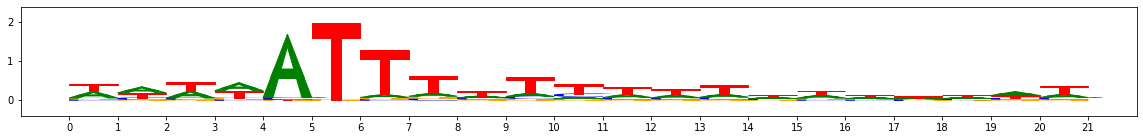

metacluster_16 4


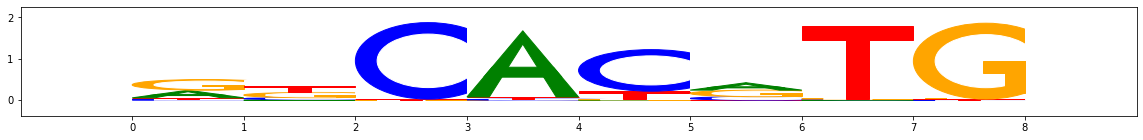

metacluster_17 0


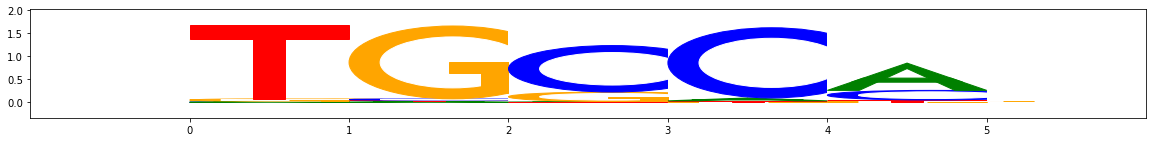

metacluster_17 1


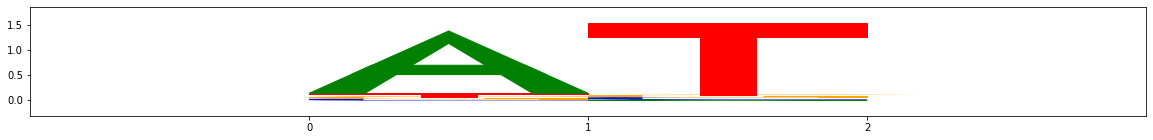

metacluster_18 0


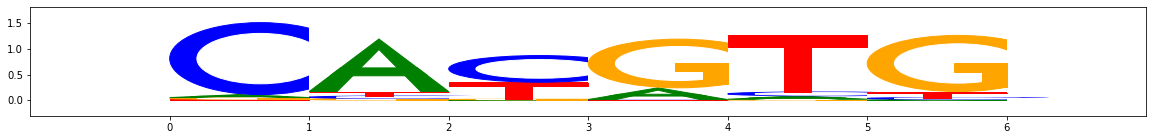

metacluster_18 1


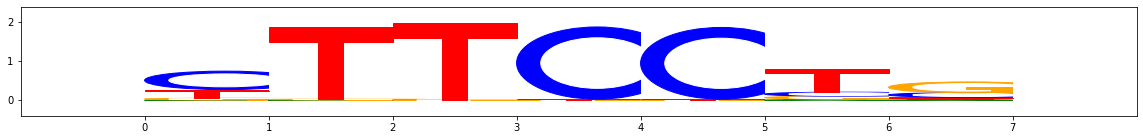

metacluster_18 2


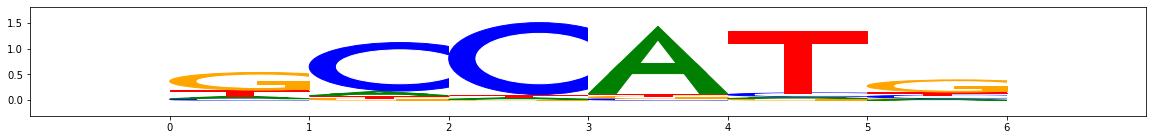

metacluster_18 3


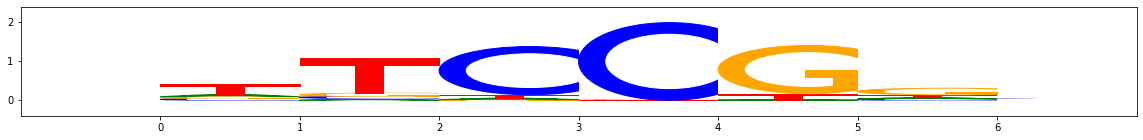

metacluster_19 0


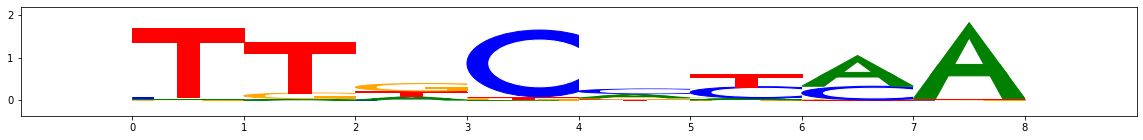

metacluster_19 1


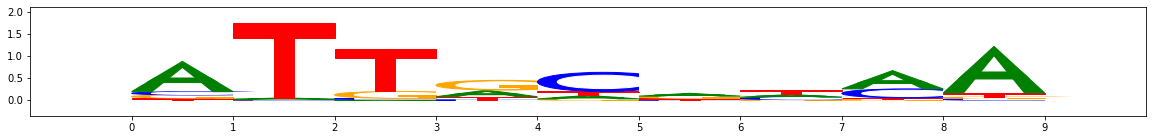

metacluster_19 2


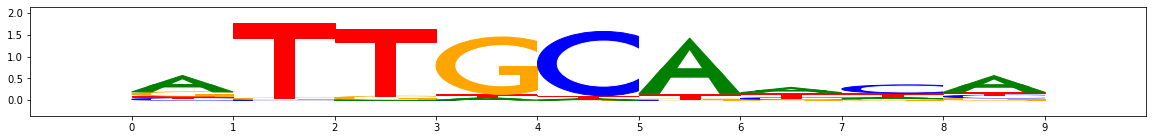

metacluster_20 0


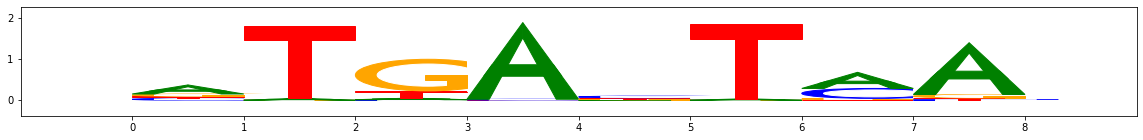

metacluster_20 1


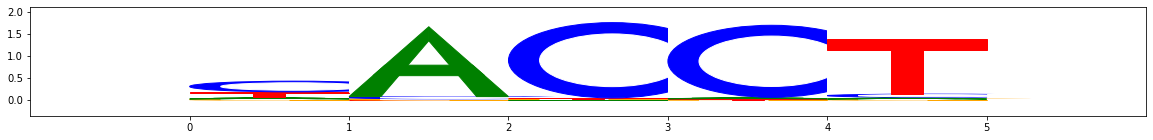

metacluster_21 0


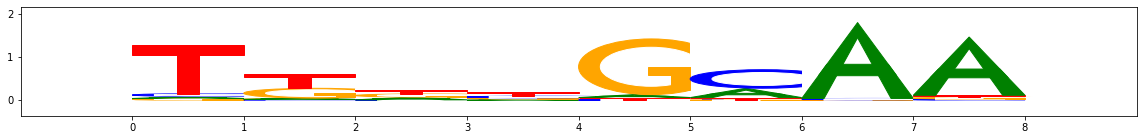

metacluster_21 1


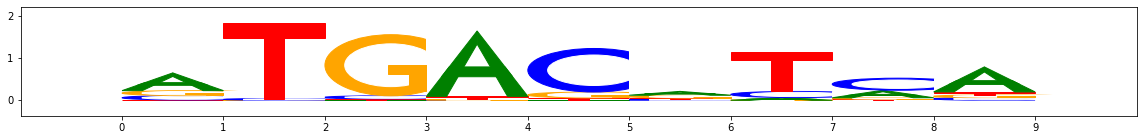

In [42]:
final_results = []
# hdf5_results = h5py.File("../../out/modisco/multi_task_deepsea_modisco.hdf5","r")
for metacluster_name in metacluster_names:
    n_patterns = len(loaded_tfmodisco_results.metacluster_idx_to_submetacluster_results[metacluster_name].seqlets_to_patterns_result.patterns)
        
    for pattern_name in range(n_patterns):
        print(metacluster_name, pattern_name)
        
        untrimmed_pattern = (loaded_tfmodisco_results.metacluster_idx_to_submetacluster_results[metacluster_name].seqlets_to_patterns_result.patterns[pattern_name])
        
        background = np.array([0.27, 0.23, 0.23, 0.27])
    
        trimmed_gata = untrimmed_pattern.trim_by_ic(ppm_track_name="sequence", background=background, threshold=0.3)
        scaled = viz_sequence.ic_scale(trimmed_gata["sequence"].fwd, background=background)
        final_results.append(scaled)
  
        viz_sequence.plot_weights(scaled)

In [43]:
len(final_results)

122

In [45]:
import pickle
with open('../../../out/modisco_pwm/modisco_pwm.pkl','wb') as f:
    pickle.dump(final_results, f)